In [1]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

pl.Config.set_tbl_rows(20)      # Increase max rows (default is 10)
pl.Config.set_tbl_cols(20)        # Increase max columns (default is 10)

polars.config.Config

In [2]:
# Load the Parquet file into a Polars DataFrame
silver_df = pl.read_parquet("data/silver_df.parquet")

# Drop unnecessary columns
silver_df = silver_df.drop(["itemid", "label", "abbreviation"])

In [3]:
# PREPARATION TO MERGE VALUE AND VALUENUM

# try casting 'value' to Float64
casted_value_to_f64 = silver_df.select(
    pl.col("value").cast(pl.Float64, strict=False).alias("value_as_f64")
)["value_as_f64"]
silver_df = silver_df.with_columns(casted_value_to_f64) # save as new column

# Keep valuenum, otherwise check if casted value exists
silver_df = silver_df.with_columns([
    pl.when(pl.col("valuenum").is_not_null())
      .then(pl.col("valuenum"))
      .otherwise(pl.col("value_as_f64"))
      .alias("valuenum"),

    # keep value only if string
    pl.when(
        (pl.col("valuenum").is_not_null()) |
        (pl.col("value_as_f64").is_not_null())
    ).then(pl.lit(None))
     .otherwise(pl.col("value"))
     .alias("value")
])

# drop the temporary column
silver_df = silver_df.drop("value_as_f64")

In [4]:
# Adjusting valueuom and value columns based on concept_id
silver_df = silver_df.with_columns([
    pl.when(pl.col("concept_id") == 45883663).then(pl.lit("bool"))
      .when(pl.col("concept_id") == 4265453).then(pl.lit("year"))
      .when(pl.col("concept_id") == 4135376).then(pl.lit("gender"))
      .otherwise(pl.col("valueuom")).alias("valueuom"),

    pl.when(pl.col("concept_id") == 45883663)
      .then(
          pl.col("value").cast(str).str.contains("nursing").fill_null(False)
      )
      .otherwise(pl.col("value"))
      .alias("value")
])

In [5]:
# Have a look at the unique concepts
unique_concepts = silver_df.select(["concept_id", "concept_name","valueuom"]).unique()

In [ ]:
# ALL TIME AGGREGATION

# 1. Mittelwert von valuenum berechnen
valuenum_means = (
    silver_df
    .group_by(["subject_id", "hadm_id", "stay_id", "concept_name"])
    .agg(pl.col("valuenum").mean().alias("mean_val"))
)

# 2. Ersten nicht-null Wert aus value erfassen
first_value_fallback = (
    silver_df
    .filter(pl.col("value").is_not_null())
    .group_by(["subject_id", "hadm_id", "stay_id", "concept_name"])
    .agg(pl.col("value").first().alias("value_fallback"))
)

# 3. Tabellen mergen
merged = valuenum_means.join(
    first_value_fallback,
    on=["subject_id", "hadm_id", "stay_id", "concept_name"],
    how="left"
)

# 4. Wenn mean_val null ist → ersatzweise value_fallback verwenden
result = merged.with_columns([
    pl.when(pl.col("mean_val").is_not_null())
      .then(pl.col("mean_val").round(2))  # ⬅️ round only numeric mean values
      .otherwise(pl.col("value_fallback"))
      .alias("final_value")
])

# 5. Pivot: wide format (concept_name → Spalten)
gold_df = (
    result
    .select(["subject_id", "hadm_id", "stay_id", "concept_name", "final_value"])
    .pivot(
        index=["subject_id", "hadm_id", "stay_id"],
        on="concept_name",
        values="final_value"
    )
)

In [ ]:
# DAY BASED AGGREGATION

# Parameter: Aggregationsintervall in Tagen
interval_hours = 1

# 1. charttime in datetime casten
df = silver_df.with_columns([
    pl.col("charttime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")])

# 2. Früheste charttime pro Fall (subj/hadm/stay)
base_times = (
    df
    .group_by(["subject_id", "hadm_id", "stay_id"])
    .agg(pl.col("charttime").min().alias("base_time"))
)

# 3. Verbinden mit Originaldaten, um base_time verfügbar zu machen
df = df.join(base_times, on=["subject_id", "hadm_id", "stay_id"], how="left")

# 4. Zeitfenster berechnen: (charttime - base_time).days // interval_days
df = df.with_columns([
    (((pl.col("charttime") - pl.col("base_time")).dt.total_hours()) // interval_hours)
    .cast(pl.Int64)
    .alias("window_id")
])
all_windows = (
    df.select(["subject_id", "hadm_id", "stay_id", "window_id"])
    .unique()
)

# 5. numerische Werte extrahieren für Aggregation
df = df.with_columns([
    pl.when(pl.col("valuenum").is_not_null())
      .then(pl.col("valuenum"))
      .otherwise(
          pl.when(pl.col("value").cast(pl.Float64, strict=False).is_not_null())
            .then(pl.col("value").cast(pl.Float64, strict=False))
      )
      .alias("numeric_value")
])

# 6a. Aggregation: Mittelwert für numerische Werte
mean_numeric = (
    df
    .group_by(["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"])
    .agg(pl.col("numeric_value").mean().round(2).alias("mean_value"))
)

# 6b. Fallback: erster String-Wert aus value, wenn keine numeric_value vorhanden
fallback_value = (
    df
    .filter(pl.col("valuenum").is_null())
    .group_by(["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"])
    .agg(pl.col("value").first().alias("fallback_value"))
)


# 7. Join der beiden Aggregationsergebnisse
merged = mean_numeric.join(
    fallback_value,
    on=["subject_id", "hadm_id", "stay_id", "window_id", "concept_name"],
    how='full', coalesce=True
)

# 8. Endwert wählen: mean_value falls vorhanden, sonst fallback_value
final = merged.with_columns([
    pl.when(pl.col("mean_value").is_not_null())
      .then(pl.col("mean_value").cast(pl.Utf8))  # cast float to string for consistency
      .otherwise(pl.col("fallback_value"))
      .alias("final_value")
])
final_filled = (
    all_windows
    .join(final, on=["subject_id", "hadm_id", "stay_id", "window_id"], how="left")
)

# 9. Pivot ins Wide-Format
days_gold_df = (
    final_filled
    .pivot(
        index=["subject_id", "hadm_id", "stay_id", "window_id"],
        on="concept_name",
        values="final_value"
    )
    .sort(["subject_id", "hadm_id", "stay_id", "window_id"])
)

# All columns to be forward filled
fill_cols = [col for col in days_gold_df.columns if col not in {"subject_id", "hadm_id", "stay_id", "window_id"}]

# Apply forward fill within each group
days_gold_df = days_gold_df.with_columns([
    pl.col(col).fill_null(strategy="forward").over(["subject_id", "hadm_id", "stay_id"])
    for col in fill_cols
])

# Assuming days_gold_df is your DataFrame
result = days_gold_df.group_by(["subject_id", "stay_id"]).agg(pl.len())

In [8]:
#null Werte müssen aufgefüllt werden für ML

#füllt nicht alle Werte, da in manchen Fällen Werte gar nicht erfasst wurden für Patienten
def fill_null_backward(df: pl.DataFrame) -> pl.DataFrame:
    sub_dfs = df.partition_by("subject_id", "hadm_id", "stay_id")   
    for i in range(len(sub_dfs)):
        sub_dfs[i] = sub_dfs[i].select(pl.all().backward_fill())
    df = pl.concat(sub_dfs)
    return df

#setze den Average des Datensatzes für null-Werte ein    
def fill_null_dataset_average(df: pl.DataFrame) -> pl.DataFrame:
    columns_to_fill = ['Glucose measurement', 'Blood urea nitrogen measurement', 'Hematocrit determination', 'Sodium measurement', 'pH measurement, arterial', 'Systolic blood pressure', 'Temperature']
    for col in columns_to_fill:
        val = round(df[col].drop_nulls().cast(pl.Float32).mean(),2)
        df = df.with_columns(pl.col(col).fill_null(val))
    return df    

In [9]:
days_gold_df = fill_null_backward(days_gold_df)
days_gold_df = fill_null_dataset_average(days_gold_df)

In [10]:
def calculate_curb65(df: pl.DataFrame) -> pl.DataFrame:
    # Spalten als Float casten (str → float), fehlerhafte Werte zu null machen
    df = df.with_columns([
        pl.col("Systolic blood pressure").cast(pl.Float64, strict=False).fill_null(0).alias("sbp"),
        pl.col("Age").cast(pl.Float64, strict=False).fill_null(0).alias("age"),
        pl.col("Blood urea nitrogen measurement").cast(pl.Float64, strict=False).fill_null(0).alias("bun"),
    ])
    
    # Punkte berechnen
    df = df.with_columns([
        # Start bei 0 + Bedingungen addieren
        (
            (pl.col("sbp") < 90).cast(pl.Int64) +
            (pl.col("age") >= 65).cast(pl.Int64) +
            (pl.col("bun") > 20).cast(pl.Int64)
        ).alias("CURB-65")
    ])
    
    # Optional: Hilfsspalten entfernen
    df = df.drop(["sbp", "age", "bun"])

    return df

In [ ]:
def calculate_psi_port(df: pl.DataFrame) -> pl.DataFrame:
    # Spalten casten (numerisch) und Nullwerte ersetzen
    df = df.with_columns([
        pl.col("Systolic blood pressure").cast(pl.Float64, strict=False).fill_null(0).alias("sbp"),
        pl.col("Temperature").cast(pl.Float64, strict=False).fill_null(0).alias("temp"),
        pl.col("pH measurement, arterial").cast(pl.Float64, strict=False).fill_null(0).alias("ph"),
        pl.col("Blood urea nitrogen measurement").cast(pl.Float64, strict=False).fill_null(0).alias("bun"),
        pl.col("Sodium measurement").cast(pl.Float64, strict=False).fill_null(0).alias("sodium"),
        pl.col("Glucose measurement").cast(pl.Float64, strict=False).fill_null(0).alias("glucose"),
        pl.col("Hematocrit determination").cast(pl.Float64, strict=False).fill_null(0).alias("hematocrit"),
        (pl.col("Nursing Home").cast(pl.Utf8).str.to_lowercase().eq("true")).alias("nursing_home"),
        pl.col("Gender").str.to_lowercase().alias("gender")
    ])

    # Score berechnen
    df = df.with_columns([
        (
            (pl.col("nursing_home") * 10) +
            ((pl.col("gender") == "f").cast(pl.Int64) * (-10)) +
            ((pl.col("sbp") < 90).cast(pl.Int64) * 20) +
            (((pl.col("temp") < 35) | (pl.col("temp") >= 40)).cast(pl.Int64) * 15) +
            ((pl.col("ph") < 7.35).cast(pl.Int64) * 30) +
            ((pl.col("bun") >= 230).cast(pl.Int64) * 20) +
            ((pl.col("sodium") < 130).cast(pl.Int64) * 20) +
            ((pl.col("glucose") >= 250).cast(pl.Int64) * 10) +
            ((pl.col("hematocrit") < 30).cast(pl.Int64) * 10) 
        ).alias("PSI/PORT")
    ])

    # Hilfsspalten entfernen
    df = df.drop([
        "sbp", "temp", "ph", "bun", "sodium", "glucose", "hematocrit", "nursing_home", "gender"
    ])

    return df

In [ ]:
# Calculate CURB-65 and PSI/PORT scores
days_gold_df = calculate_curb65(days_gold_df)
days_gold_df = calculate_psi_port(days_gold_df)

['subject_id', 'hadm_id', 'stay_id', 'window_id', 'Systolic blood pressure', 'Sodium measurement', 'Glucose measurement', 'Blood urea nitrogen measurement', 'Hematocrit determination', 'pH measurement, arterial', 'Age', 'Gender', 'Nursing Home', 'Temperature', 'CURB-65', 'PSI/PORT']


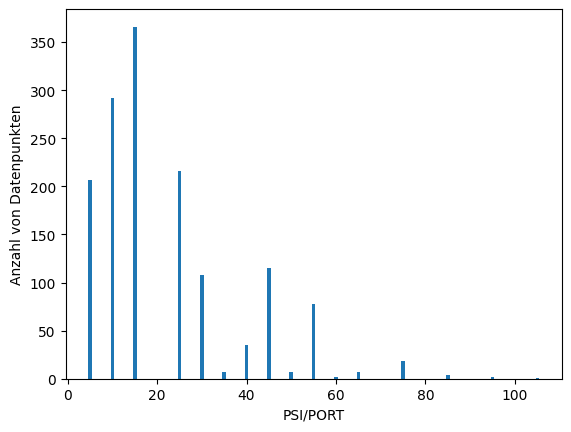

shape: (16, 2)
┌──────────┬─────┐
│ PSI/PORT ┆ len │
│ ---      ┆ --- │
│ i64      ┆ u32 │
╞══════════╪═════╡
│ 105      ┆ 1   │
│ 50       ┆ 7   │
│ 10       ┆ 292 │
│ 55       ┆ 78  │
│ 75       ┆ 18  │
│ 5        ┆ 207 │
│ 30       ┆ 108 │
│ 65       ┆ 7   │
│ 15       ┆ 366 │
│ 35       ┆ 7   │
│ 85       ┆ 4   │
│ 25       ┆ 216 │
│ 60       ┆ 2   │
│ 45       ┆ 115 │
│ 95       ┆ 2   │
│ 40       ┆ 35  │
└──────────┴─────┘


<Axes: xlabel='PSI/PORT', ylabel='Density'>

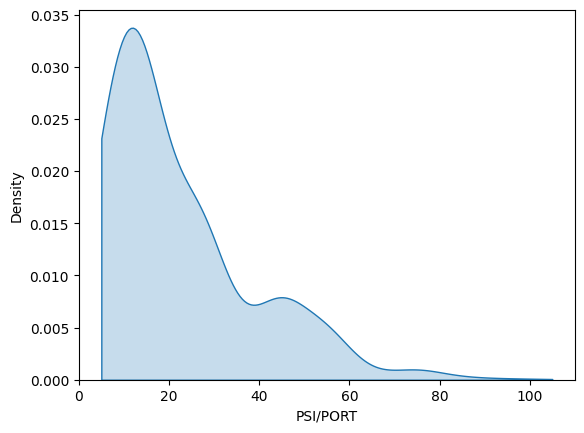

In [ ]:
# Save as parquet file
days_gold_df.write_parquet("data/gold_df.parquet")
print(days_gold_df.columns)
res = (days_gold_df.group_by(["PSI/PORT"]).agg(pl.len()))
plt.bar(res["PSI/PORT"], res["len"])
plt.xlabel("PSI/PORT")
plt.ylabel("Anzahl von Datenpunkten")
plt.savefig("distr_psi.png")
plt.show()
print(res)
sns.kdeplot(data=days_gold_df, x="PSI/PORT", cut=0, bw_adjust=1.5, fill=True)

In [14]:
pdf = days_gold_df.to_pandas()
grouped = pdf.groupby(['subject_id', 'hadm_id', 'stay_id'])

n = len(grouped)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Sammle alle CURB-65 Werte, um globale Min/Max für die gemeinsame Skalierung zu bestimmen
all_curb65 = pdf['CURB-65']
curb_min = all_curb65.min()
curb_max = all_curb65.max()

for i, ((subject_id, hadm_id, stay_id), group) in enumerate(grouped):
    group_sorted = group.sort_values('window_id')
    
    ax1 = axes[i]
    ax1.plot(group_sorted['window_id'], group_sorted['PSI/PORT'], marker='o', color='tab:blue', label='PSI/PORT')
    ax1.set_title(f'Subject {subject_id}, HADM {hadm_id}, STAY {stay_id}')
    ax1.set_xlabel('window_id')
    ax1.set_ylabel('PSI/PORT', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(group_sorted['window_id'], group_sorted['CURB-65'], marker='x', linestyle='--', color='tab:red', label='CURB-65')
    ax2.set_ylabel('CURB-65', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Setze für alle CURB-65-Achsen dieselbe y-Lim und Integer-Ticks
    ax2.set_ylim(curb_min - 0.5, curb_max + 0.5)  # etwas Puffer
    ax2.set_yticks(np.arange(curb_min, curb_max + 1, 1))  # Integer-Ticks

# Nicht verwendete Subplots entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [23]:
patient_df = days_gold_df.filter(
    (pl.col('subject_id') == 10021487) & 
    (pl.col('hadm_id') == 28998349) & 
    (pl.col('stay_id') == 38197705)
).to_pandas()

patient_df = patient_df.sort_values('window_id')

columns_to_plot = [
    'Sodium measurement',
    'Blood urea nitrogen measurement',
    'Glucose measurement',
    'Systolic blood pressure',
    'Hematocrit determination',
    'pH measurement, arterial',
    'Temperature'
]

# Fehlende Werte behandeln: "none" in NaN umwandeln und zu numerisch konvertieren
for col in columns_to_plot:
    patient_df[col] = patient_df[col].replace('none', np.nan)
    patient_df[col] = pd.to_numeric(patient_df[col], errors='coerce')

plt.figure(figsize=(12, 6))

for col in columns_to_plot:
    # Prüfe, ob es mindestens einen validen Wert gibt
    if patient_df[col].notna().any():
        plt.plot(patient_df['window_id'], patient_df[col], marker='o', label=col)

plt.title('Verlauf verschiedener Messwerte für Patient 10021487')
plt.xlabel('window_id')
plt.ylabel('Messwerte')
plt.legend(loc='center right')
plt.grid(True)
plt.show()